In [1]:
from recognition_facenet.recognition import face_encodings,model,_detectSingleFace,pnet_fun,rnet_fun,onet_fun
import cv2
import numpy as np
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
import os
from facenet.align.detect_face import detect_face,create_mtcnn
from common import ROC_AUC,plotROC
from recognition_facenet.ImageProcess import equalization,modify_autoContract
%matplotlib inline

/home/zhangxk/projects/deepAI/daily/8/mysite/facenet/align
load model from /home/zhangxk/projects/deepAI/daily/8/mysite/recognition_facenet/model

Instructions for updating:
To construct input pipelines, use the `tf.data` module.



Model directory: /home/zhangxk/projects/deepAI/daily/8/mysite/recognition_facenet/model
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275


In [2]:
dbFile='./webapp/facedb1'
dbs=[]
fnames=[]
for f in os.listdir(dbFile):
#     face=_detectSingleFace(os.path.join(dbFile,f),pad=22,preprocsingFunc=equalization)
#     face_encode=model.predict([face])[0]
    face_encode=face_encodings(os.path.join(dbFile,f),pad=22,prefunc=modify_autoContract)[0]
#     face_encode=face_encodings(os.path.join(dbFile,f))[0]
    dbs.append(face_encode)
    fnames.append(f)
dbs=np.array(dbs)
print(dbs.shape)

(16, 512)


In [4]:
# array([-0.06402157,  0.04419756, -0.0109132 ,  0.02123769], dtype=float32)
dbs[0][[0,3,5,6]]

array([-0.06402157,  0.04419756, -0.0109132 ,  0.02123769], dtype=float32)

In [5]:
def readDetectFile(fs='./webapp/detect/'):
    '''
    read files under fs,return a list of images[HxWxC]
    '''
    images=[]
    for f in os.listdir(fs):
        I=imread(os.path.join(fs,f),mode='RGB')
        I=modify_autoContract(I)
        images.append(I)
    return images
def alignImage(images,minsize=50, threshold = [0.6, 0.7, 0.7], factor=0.709,pad=0,image_size=160,savePath=None):
    '''
        images is a list of images,I want to find the face of each image using MTCNN
        return a align verson of images,some face may fail to detect,so len(ret)<=len(images)
    '''
    ret=[]
    for i,I in enumerate(images):
        box, point=detect_face(I,minsize,pnet_fun,rnet_fun,onet_fun,threshold,factor)

        if len(box)==0:continue

        h,w=I.shape[0:2]
        x1, y1, x2, y2, acc = box[0]
        x1, y1, x2, y2 = max(x1-pad, 0), max(y1-pad, 0), min(x2+pad, w), min(y2+pad, h)
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        cropped=I[y1:y2,x1:x2]
        aligned = imresize(cropped, (image_size, image_size), interp='bilinear')
        if savePath:
            plt.imsave(os.path.join(savePath,str(i)+'.png'),cropped)
            plt.imsave(os.path.join(savePath,str(i)+'_align.png'),aligned)
        ret.append(aligned)
    return ret

detectImages      =readDetectFile()
print('# of faces:',len(detectImages))
align_detectImages=alignImage(detectImages,savePath='./webapp/detect_align',pad=22)
print('# of align faces:',len(align_detectImages))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


# of faces: 252
# of align faces: 250


In [6]:
def writenface(images): 
    '''
        set mean=0,std=1,do not care about spatial imformation
    '''
    images=np.array(images)
    
    m,h,w,c=images.shape
    images.shape=(m,h*w*c)
    
    u=np.mean(images,axis=1,keepdims=True)
    s=np.std(images,axis=1,keepdims=True)
    images= (images-u)/s
    images.shape=(m,h,w,c)
    return images
writen_faces=writenface(align_detectImages)
#after writen,I compute feature of each face
batch=32
batchcodes=[]
m=len(writen_faces)
steps= int(np.ceil(m/batch))
for s in range(steps):
    code=model.predict(writen_faces[s*batch:(s+1)*batch])
    batchcodes.append(code)
batchcodes=np.concatenate(batchcodes,axis=0)

In [7]:
#I want be cool ,so I using this fancy policy to compute disi<Xi,Bj>
def computeSimiliary(s,b):
    '''
        s mxn
        b kxn
        return sb have shape mxk
        sb[i,j]=|si-bj|
    '''
    s,b=s.copy(),b.copy()
    s=np.expand_dims(s,axis=1) #mx1xn
    b=np.expand_dims(b,axis=0) #1xk*n
    sb=np.linalg.norm(s-b,axis=2)
    return sb
MK=computeSimiliary(batchcodes,dbs)

  michelle obama.jpg:mean=1.4395 ,std=0.0395
               3.png:mean=0.8192 ,std=0.0667
      steve jobs.jpg:mean=1.5239 ,std=0.0328
       liv tyler.jpg:mean=1.4464 ,std=0.0345
  martina hingis.jpg:mean=1.4861 ,std=0.0327
               1.png:mean=1.0766 ,std=0.0507
               2.png:mean=0.9905 ,std=0.0549
               8.jpg:mean=1.0421 ,std=0.0575
            bill.jpg:mean=1.3118 ,std=0.0406
    aaron carter.jpg:mean=1.3054 ,std=0.0480
               6.png:mean=0.7712 ,std=0.0613
         zhangxk.png:mean=0.5237 ,std=0.0936
    adrien brody.jpg:mean=1.3781 ,std=0.0452
               4.png:mean=1.0904 ,std=0.0509
      adam brody.jpg:mean=1.3421 ,std=0.0450
               5.png:mean=1.0275 ,std=0.0507


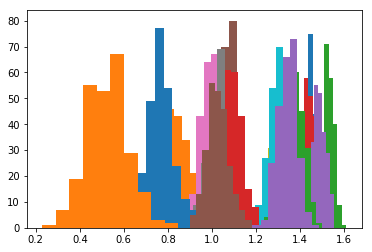

In [8]:
#for zhangxk.png
# u=0.5150 ,std=0.0932
# zhangxk.png:mean=0.5271 ,std=0.0911
# zhangxk.png:mean=0.5020 ,std=0.0905 with equalization
# [0.44967447966337204 0.6741776540875435]
for k in range(MK.shape[1]):
    dists=MK[:,k]
    u,s=np.mean(dists),np.std(dists)
    plt.hist(dists)
    print('%20s:mean=%.4f ,std=%.4f'%(fnames[k],u,s))
#     print(u-1*s,u+1*s)

best rule is score<=0.680630,under this rule,TPR is 0.952000,FPR is 0.004533
accuracy is 0.9928


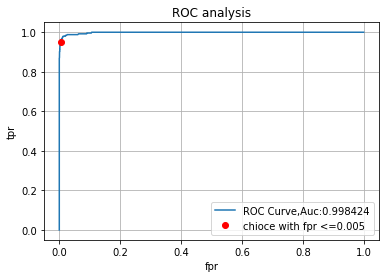

In [9]:
from sklearn.metrics import roc_auc_score,auc
K=fnames.index('zhangxk.png') #I am cheat
y=np.zeros(MK.shape)
y[:,K]=1
y=y.astype(np.bool8)

thresold=np.linspace(0.01,2,1000,endpoint=False)
TPR,FPR,acc=[],[],[]
for t in thresold:
    yhat=(MK<=t)
    TP=np.sum(y*yhat)
    FP=np.sum((~y)*yhat)
    TN=np.sum((~y)*(~yhat))
    FN=np.sum(y*(~yhat))
    TPR.append((TP)/(TP+FN))
    FPR.append((FP)/(FP+TN))
    acc.append((TP+TN)/(TP+TN+FP+FN))
TPR,FPR=np.array(TPR),np.array(FPR)
# best rule is score<=0.702520,under this rule,TPR is 0.892000,FPR is 0.009067
# best rule is score<=0.666700,under this rule,TPR is 0.948000,FPR is 0.004800
# best rule is score<=0.680630,under this rule,TPR is 0.952000,FPR is 0.004533,using auto_contract
# best rule is score<=0.670680,under this rule,TPR is 0.944444,FPR is 0.004233,using equalization

plotROC(FPR,TPR,auc(FPR,TPR),thresold,0.005,acc)
# the criteria is if yhat<=t  then y=1 for ROC_AUC rule,and also is my policy
#something wrong with it
# fp,tp,thresolds,auc=ROC_AUC(y.ravel(),yhat.ravel(),flag='binary')
# plotROC(fp,tp,auc,thresolds,.1)

# print(acc)

### I will show that the jagged result between same person,My goal is to reduce mean and stand diveratoin!

sample size is : 31125
true answer is , 31125.0
0.5480021 0.11324994
0.3215022385120392 0.7745020091533661


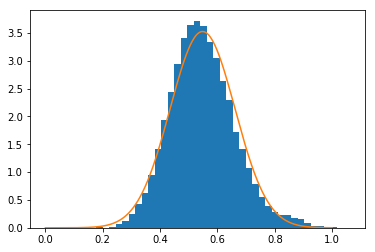

In [10]:

D=batchcodes.dot(batchcodes.T)
A=np.diag(D)
A.shape=(-1,1)
nsquare=A+A.T-2*D
dists=nsquare**(0.5)
# dists[i,j] is distance between xi,xj,so I only want upper triangle part
dists=np.triu(dists,1)
dists=dists[dists>0]
print('sample size is :',len(dists))
print('true answer is ,',(m*m-m)/2)
plt.hist(dists,40,normed=True)
u,s=np.mean(dists),np.std(dists)
# sample size is : 31125
# true answer is , 31125.0
# 0.60630655 0.12857589
# 0.4777306616306305 0.7348824441432953
print(u,s)
print(u-2*s,u+2*s)

def pdf(x,u,sigma):
    return np.exp(-((x-u)**2) /(2*sigma*sigma))/(np.sqrt(2*np.pi)*sigma)
x=np.linspace(0,1,1000)
y=pdf(x,u,s)
plt.plot(x,y)